In [ ]:
#pip install tf_keras

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-04-28 09:39:30.694888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 09:39:30.695000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 09:39:30.822012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.15.0


In [4]:
df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

<Axes: xlabel='sentiment'>

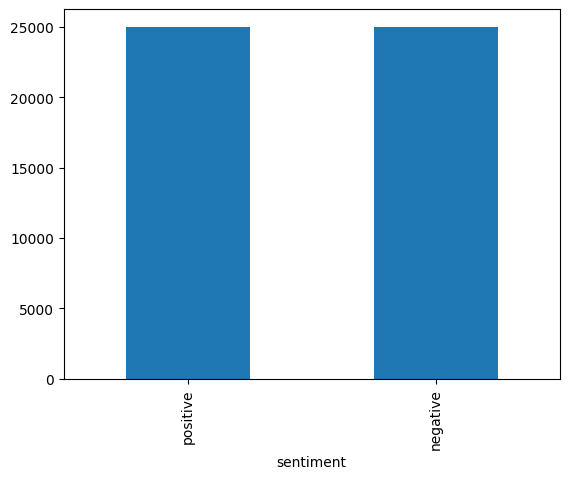

In [8]:
counts = df['sentiment'].value_counts()
counts.plot(kind='bar')

In [9]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [35]:
# First split: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'].to_numpy(),df['sentiment'].to_numpy(), test_size=0.2, random_state=42)

# Second split: Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [36]:
len(X_train), len(X_test), len(X_val), len(y_train), len(y_test), len(y_val)

(32000, 10000, 8000, 32000, 10000, 8000)

In [37]:
X_train[:2],y_train[:2]

(array(["With no fault to the actors (they all put on great performances), the overall story was not very well executed. The movie opens with a great zinger: a crazy old guy forces a young Aborigine girl's car off the road. But then, we're forced to endure 40 minutes of character development with an entirely new group of characters ... and we don't know why until the 40 minutes are up. It turns out that they are the ones who eventually discover the girl's body ... and the story progresses from there.<br /><br />While the story does pick up at that point, it really goes nowhere. After 2 hours, I asked myself: was there a point to this, or was it just to see the characters struggle with accusations of racism and stupidity of how they handled the discovery? The story was ultimately unsatisfying and felt unfinished. While it is well acted, there's not a strong enough backbone in the film to warrant recommending it.",
        'The first thing I thought when I saw this films was: It is not r

# Base Model using Naive Bayes

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_nb = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])



In [39]:
# Fit the pipeline to the training data
model_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [40]:
baseline_score = model_nb.score(X_test, y_test)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 86.08%


In [41]:
# Make predictions
baseline_preds = model_nb.predict(X_test)
baseline_preds[:5]

array([1, 1, 0, 1, 0])

# Using RNN Model

In [42]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

231

In [43]:

# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in X_train]
sent_lens[:5]

[164, 222, 309, 140, 131]

In [44]:
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

230.57871875

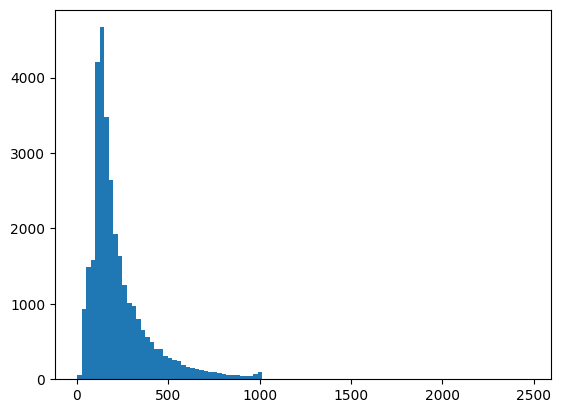

In [45]:

# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=100);

In [46]:

# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

588

In [47]:
unique_words=set()
[unique_words.update(sentence.split()) for sentence in X_train]

unique_words_list = list(unique_words)
print(unique_words_list[:5])
len(unique_words)


['better/', 'speakeasy,', 'Cockney', 'perfection.', '"Spirited']


330413

### Tokenize the words

In [48]:
max_vocab_length = 20000
sentence_length = 230

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization


text_vectorizer = TextVectorization(max_tokens=max_vocab_length, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=sentence_length) 
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [50]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [51]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
This film does a superb job of depicting the plight of an ALS (Lou Gehrig's Disease)sufferer. The subject is done with compassion as well as humor. Helena Bonham Carter is so convincing as a person with ALS that I found it hard to believe that she was only acting. Kenneth Branagh, a superb actor, lives up to expectations as the quirky artist who misbehaves and is forced to provide companionship to Helena's character as part of his "community service", an alternative to prison time. Watching the development of the relationship between these two is a treat from beginning to end. Tha fact that it is a fairy tale does not detract from the fabulous performances. One comes to care deeply for the two of them.      

Vectorized version:


<tf.Tensor: shape=(1, 230), dtype=int64, numpy=
array([[   11,    20,   122,     4,   880,   292,     5,  4821,     2,
         4907,     5,    34, 16227,  4118,     1,     1,     2,   738,
            7,   223,    17,  5638,    15,    74,    15,   463, 11776,
        14698,  4479,     7,    38,  1082,    15,     4,   409,    17,
        16227,    12,     9,   244,    10,   264,     6,   251,    12,
           59,    14,    62,   113,  4621,  4929,     4,   880,   291,
          465,    57,     6,  1416,    15,     2,  2677,  1840,    37,
            1,     3,     7,   851,     6,  1624, 14251,     6,     1,
          110,    15,   170,     5,    25,  1850,  2307,    34,  4212,
            6,  1209,    60,   146,     2,   956,     5,     2,   634,
          198,   131,   107,     7,     4,  1821,    36,   449,     6,
          128, 18998,   184,    12,    10,     7,     4,  3286,   777,
          122,    22,  6896,    36,     2,  2890,   354,    29,   263,
            6,   462,  1695, 

In [16]:
_# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 20000
Top 5 most common words: ['', '[UNK]', 'the', 'and', 'a']
Bottom 5 least common words: ['triggers', 'trelkovsky', 'transportation', 'transfers', 'trainbr']


### Create an Embedding Layer

In [17]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=sentence_length, # how long is each input
                             name="embedding_1") 

embedding

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [52]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
I remember hearing about this movie and how it played at nearly every drive-in theatre here in Toronto. It's about a group of girls that are not accepted by the other sororities at their college, so they start up their own, and of course call it H.O.T.S. It's a fun movie, that is just bursting with drive-in nostalgia! Lots of fully endowed t-shirts, vans, fighting, and a football game showdown like no other! It's been compared to "Animal House", which is a good movie in it's own right, but to me nothing compares to H.O.T.S. It has it's own brand of fun & character. If you are looking for a classic T n'A movie, look no further because the H.O.T.S. girls are to the rescue, boom-boom shorts & all!      

Embedded version:


<tf.Tensor: shape=(1, 230, 128), dtype=float32, numpy=
array([[[-0.00412143, -0.00890472, -0.00224628, ..., -0.01213391,
          0.00826461, -0.01750404],
        [-0.01528545, -0.01630871,  0.03650006, ..., -0.04685836,
          0.04000336, -0.03339604],
        [ 0.04615158, -0.02031076, -0.03416605, ...,  0.00564937,
          0.04955417, -0.00322763],
        ...,
        [-0.01787928, -0.03041354,  0.01975325, ..., -0.04323336,
         -0.01100911,  0.03007075],
        [-0.01787928, -0.03041354,  0.01975325, ..., -0.04323336,
         -0.01100911,  0.03007075],
        [-0.01787928, -0.03041354,  0.01975325, ..., -0.04323336,
         -0.01100911,  0.03007075]]], dtype=float32)>

## Creating LSTM Model

In [53]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_rnn_embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             embeddings_initializer="uniform", #
                             input_length=sentence_length, 
                             name="embedding_1") 


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_rnn_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_rnn = tf.keras.Model(inputs, outputs, name="model_rnn_LSTM")

(None, 230, 128)
(None, 64)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
# Compile model
model_rnn.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
model_rnn.summary()

Model: "model_rnn_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 230)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 230, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 230, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,642,497 (10.08 MB)

 Trainable params: 2,642,497 (10.08 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Fit model
model_rnn_history = model_rnn.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.5037 - loss: 0.6928 - val_accuracy: 0.5051 - val_loss: 0.6913
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.5551 - loss: 0.6750 - val_accuracy: 0.5216 - val_loss: 0.6912
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.6173 - loss: 0.6255 - val_accuracy: 0.7660 - val_loss: 0.4769
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8175 - loss: 0.3988 - val_accuracy: 0.8321 - val_loss: 0.3876
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8758 - loss: 0.3001 - val_accuracy: 0.8359 - val_loss: 0.4128


<Axes: >

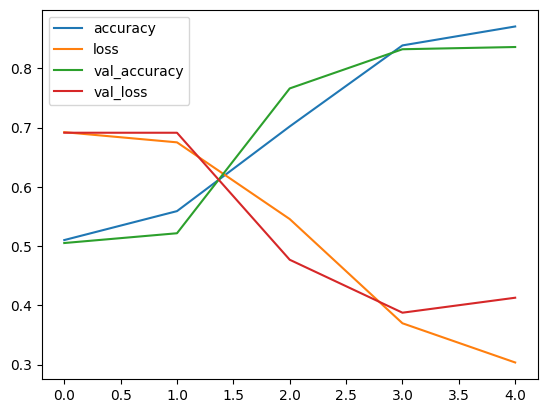

In [57]:
pd.DataFrame(model_rnn_history.history).plot()

In [58]:
loss, accuracy = model_rnn.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8314 - loss: 0.4052
Model loss on the test set: 0.4017106592655182
Model accuracy on the test set: 83.64%


## Creating GRU Model

In [59]:
model_rnn_embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             embeddings_initializer="uniform", #
                             input_length=sentence_length, 
                             name="embedding_1") 


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_rnn_embedding(x)
print(x.shape)
x = layers.GRU(64, return_sequences=True)(x) # (you can stack RNN cells as long as return_sequences=True)
x = layers.GRU(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_gru = tf.keras.Model(inputs, outputs, name="model_rnn_LSTM")

(None, 230, 128)
(None, 64)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [62]:
# Compile GRU model
model_gru.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
# Get a summary of the GRU model
model_gru.summary()

Model: "model_rnn_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 230)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 230, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 230, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,622,273 (10.00 MB)

 Trainable params: 2,622,273 (10.00 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Fit model
model_gru_history = model_gru.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5005 - loss: 0.6931 - val_accuracy: 0.5956 - val_loss: 0.6740
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.7096 - loss: 0.5233 - val_accuracy: 0.8851 - val_loss: 0.2802
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9182 - loss: 0.2094 - val_accuracy: 0.8889 - val_loss: 0.3323
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9636 - loss: 0.1066 - val_accuracy: 0.8660 - val_loss: 0.4919
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9852 - loss: 0.0526 - val_accuracy: 0.8608 - val_loss: 0.5740


<Axes: >

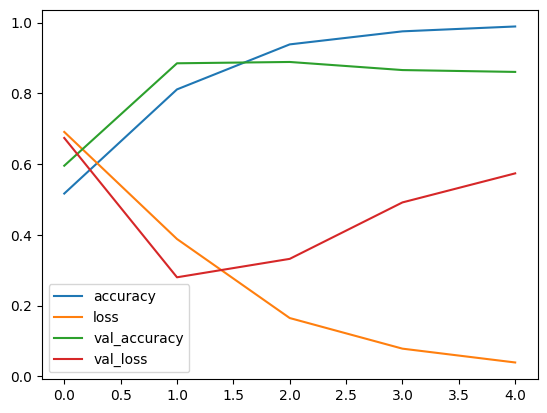

In [66]:
pd.DataFrame(model_gru_history.history).plot()

In [67]:
loss, accuracy = model_gru.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8628 - loss: 0.5471
Model loss on the test set: 0.5496600866317749
Model accuracy on the test set: 86.31%


## Birection LSTM

In [76]:

model_rnn_embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             embeddings_initializer="uniform", #
                             input_length=sentence_length, 
                             name="embedding_1") 


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_rnn_embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x) # (you can stack RNN cells as long as return_sequences=True)
x = layers.Bidirectional(layers.LSTM(64))(x)
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_bidirectional = tf.keras.Model(inputs, outputs, name="model_rnn_LSTM")

(None, 230, 128)
(None, 128)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [77]:
# Compile Birectional model
model_bidirectional.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [80]:
model_bidirectional_histroy = model_bidirectional.fit(X_train,
                                                      y_train,
                                                      epochs=5,
                                                      validation_data=(X_val,y_val))

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.7125 - loss: 0.5498 - val_accuracy: 0.8466 - val_loss: 0.3636
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.8778 - loss: 0.2996 - val_accuracy: 0.8829 - val_loss: 0.2913
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.9216 - loss: 0.2011 - val_accuracy: 0.8796 - val_loss: 0.3366
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.9523 - loss: 0.1416 - val_accuracy: 0.8774 - val_loss: 0.3854
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.9687 - loss: 0.0937 - val_accuracy: 0.8720 - val_loss: 0.4405


<Axes: >

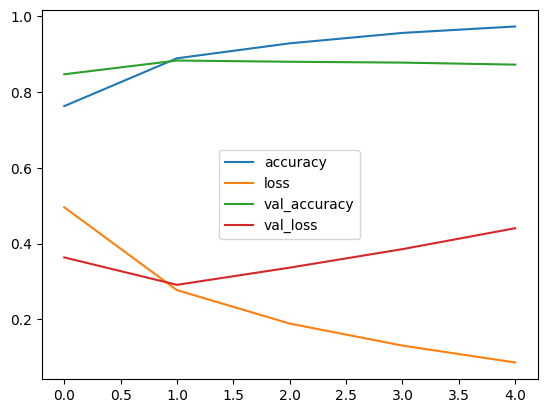

In [85]:
pd.DataFrame(model_bidirectional_histroy.history).plot()

In [87]:
model_bidirectional.evaluate(X_test,y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8777 - loss: 0.4102
Model loss on the test set: 0.5496600866317749
Model accuracy on the test set: 86.31%


# How many people like the movie (Movie Rater)

In [173]:
# All texts must be within the list and converted to nparray and object should be object
movie_comment= ["Vijay's ghilli is an thriller movie which make all people to come to theatre", "movie not good", 
                "great action movie","vijay acting is loved by children","songs are great"]

In [174]:
pred_probs=model_bidirectional.predict(np.fromiter(movie_comment, dtype=object))
pred_probs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.90754265],
       [0.42257002],
       [0.9924757 ],
       [0.9960419 ],
       [0.85574514]], dtype=float32)

In [175]:
pred_label = tf.squeeze(tf.round(pred_probs)).numpy()
list(pred_label)

[1.0, 0.0, 1.0, 1.0, 1.0]

In [176]:
print(f"{(list(pred_label).count(1)/len(movie_comment))*100} people like this movie")

80.0 people like this movie
